# Outdoor path finding from a map and a list of obstacles

Author : Anass El Yaagoubi

- Image Binarization
- Add obstacles (artificial but could be loaded from ground truth)
- Voronoï Diagram
- Apply a path finding algorithm on the graph

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import random
import networkx as nx
random.seed(0)

### Loading the map

In [2]:
img_ = Image.open('../../outdoorMap.png')
img  = np.array(img_)

myMap = np.zeros(img.shape)
myMap[img == (217, 208, 201, 255)] = 1
myMap = myMap[:, :, 0]

###  Visualization

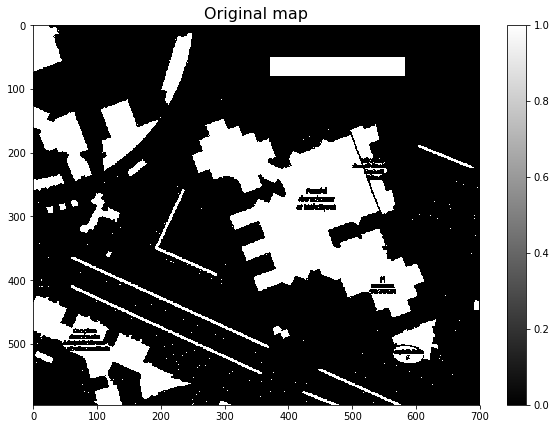

In [3]:
plt.figure(figsize=(10, 10))
plt.title('Original map', fontsize=16)
plt.imshow(myMap, cmap='gray')
plt.colorbar(shrink=0.7)
plt.show()